# Inversão não linear de dados de grav para estimar o relevo de uma bacia sedimentar

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import harmonica as hm
import bordado as bd
from scipy.optimize import minimize


## Gerar dados sintéticos

In [2]:
def gaussiana(x, amplitude, deslocamento, desvio_padrao):
    return amplitude * np.exp(-((x-deslocamento)/desvio_padrao)**2)

def sintetico():
    n_prismas = 100
    x_min, x_max = 10e3, 90e3
    x = bd.line_coordinates(x_min, x_max, size=n_prismas, pixel_register=True)
    profundidades = (
        gaussiana(x, amplitude=5e3, deslocamento=40e3, desvio_padrao=20e3)
        + gaussiana(x, amplitude=2e3, deslocamento=80e3, desvio_padrao=10e3)
        + gaussiana(x, amplitude=2e3, deslocamento=30e3, desvio_padrao=10e3)
    )
    profundidades -= profundidades.min()
    return profundidades, x_min, x_max

def plota_prismas(profundidades, x_min, x_max, ax=None, figsize=(9,3)):
    bordas = bd.line_coordinates(x_min, x_max, size=profundidades.size+1)
    x = [x_min]
    y = [0]
    for i in range(profundidades.size):
        x.extend([bordas[i], bordas[i+1]])
        y.extend([profundidades[i], profundidades[i]])
    x.append(x_max)
    y.append(0)
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=figsize)
        ax.set_xlabel("x[m]")
        ax.set_ylabel("profundidade[m]")
        ax.set_ylim(np.max(profundidades)*1.05, 0)
    ax.set_ylim(np.max(profundidades)*1.05, 0)  
    ax.plot(x,y)

    return ax

<Axes: xlabel='x[m]', ylabel='profundidade[m]'>

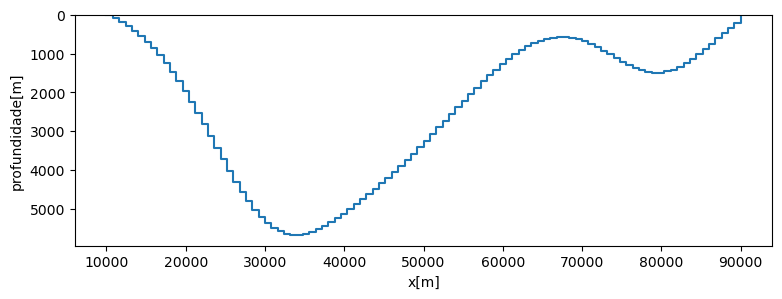

In [3]:
profundidades, x_min, x_max = sintetico()
plota_prismas(profundidades, x_min, x_max)

In [4]:
def modelagem_direta(profundidades, x_min, x_max, x, contraste_densidade):
    coordinates = (x, np.zeros_like(x), np.zeros_like(x))
    bordas = bd.line_coordinates(x_min, x_max, size = profundidades.size + 1)
    prismas = []
    for i in range(profundidades.size):
        if profundidades[i] >=0:
            base = -profundidades[i]
            topo = 0
        else:
            topo = -profundidades[i]
            base = 0

    prismas = [
        [bordas[i], bordas[i+1], -500e3, 500e3, -profundidades[i], 0]
        for i in range(profundidades.size)
    ]

    dados = hm.prism_gravity(coordinates, prismas, np.full_like(profundidades, contraste_densidade), field="g_z")
    return dados

In [5]:
x = bd.line_coordinates(0,100e3, size=60)
contraste_densidade = -200 #kg/m³

dados = modelagem_direta(profundidades, x_min, x_max, x, contraste_densidade)
# dados += np.random.default_rng()

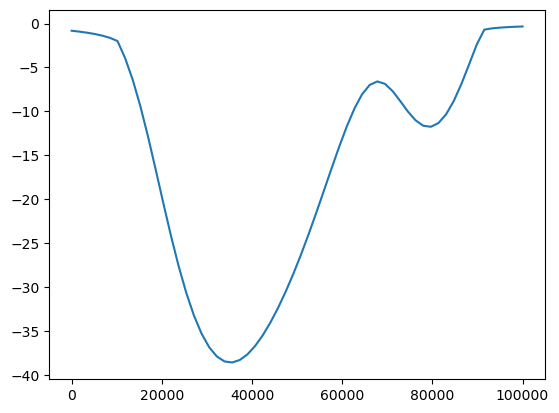

In [6]:
plt.plot(x, dados)

<Axes: >

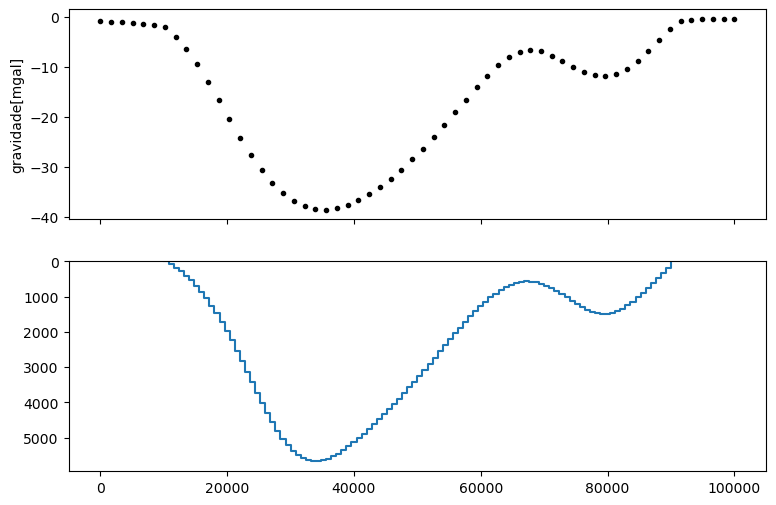

In [7]:
fig, axes = plt.subplots(2,1, figsize=(9,6), sharex=True)

ax = axes[0]
ax.plot(x, dados, ".k")
ax.set_ylabel("gravidade[mgal]")

plota_prismas(profundidades, x_min, x_max, ax=axes[1])


## Inversão com método de Newton

In [9]:
def jacobian(x, p, x_min, x_max, contraste_densidade, delta_z=10):
    M = p.size
    N = x.size
    # Construir a jacobiana
    A = np.empty((N, M))

    coordinates = (x, np.zeros_like(x), np.zeros_like(x))

    for j in range(M):
        delta_z = 10
        bordas = bd.line_coordinates(x_min, x_max, size=M + 1)
        if profundidades[i] >=0:
            base = -(p[j]+delta_z)
            topo = 0
        else:
            topo = -(p[j]+delta_z)
            base = 0

        prisma_j_mais = [bordas[j], bordas[j+1], -500e3, 500e3, topo,base]
        prisma_j_menos = [bordas[j], bordas[j+1], -500e3, 500e3, topo, base]
        g_mais =  hm.prism_gravity(coordinates, prisma_j_mais , np.full_like(M, contraste_densidade), field="g_z")  # vetor com N elementos
        g_menos = hm.prism_gravity(coordinates, prisma_j_menos, np.full_like(M, contraste_densidade), field="g_z")

        A[:, j] = (g_mais - g_menos) / (2 * delta_z)

    return A

In [10]:
M = 20 # númro de parâmetros
p = np.full(M, 5000)# chute inicial (vetor de M elementos)

residuo = dados - modelagem_direta(p, x_min, x_max, x, contraste_densidade)
funcao_objetivo = [np.linalg.norm(residuo)**2]
max_iteracoes=50

tol = 0.01
for iteracao in range(max_iteracoes):
    A = jacobian(x, p, x_min, x_max, contraste_densidade)
    delta_p = np.linalg.solve(A.T @ A, A.T @ residuo)
    p = p + delta_p
    residuo = dados - modelagem_direta(p, x_min, x_max, x, contraste_densidade)
    funcao_objetivo.append(np.linalg.norm(residuo)**2)
    if (funcao_objetivo[-1]-funcao_objetivo[-2])/funcao_objetivo[-2] < tol:
        break



NameError: name 'i' is not defined